# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


# TD9 : Régression bayésienne

La régression ridge est un cas particulier de la régression linéaire bayésienne lorsque la loi *a priori* partiellement informative suivante est utilisée :
$$ f_{(\boldsymbol{\beta},\sigma^2)}(\boldsymbol{\beta},\sigma^2) \propto \mathcal{N}\left(\boldsymbol{\beta} \, \left| \, \boldsymbol{0}_p , \frac{\sigma^2}{\lambda}I_p \right. \right) \times \frac{1}{\sigma^2}. $$
Pour être conséquent avec l'approche bayésienne, il faudrait fixer l'hyperparamètre $\lambda$ avant même d'avoir vu les données. De façon pragmatique, la valeur de $\lambda$ est souvent choisie par validation comme nous le ferons dans cet exercice.

## Données

Le jeu de données étudiées pour l'exercice 1 provient de l'étude de Tibshirani et al. (2004) illustrant les méthodes de régression modernes telle que la régression ridge. Nous étudierons la glycémie sanguine (glu) en fonction de 8 variables explicatives : l'âge du patient (age), l'indice de masse corporel du patient (bmi), de la tension artérielle moyenne (map) ainsi que de 5 autres indicateur sanguins (tc, ldl, hdl, tch et ltg). Nous laissons tomber dans le caadre de ce TD le sexe du patient et la variable prog.


#### Référence
Tibshirani, R. J., Johnstone, I., Hastie, T., & Efron, B. (2004). Least angle regression. *The Annals of Statistics*, 32(2), 407–499. DOI:10.1214/009053604000000067


In [2]:
using CSV 
using DataFrames
using Distributions
using Gadfly
using LinearAlgebra
import Random
using Statistics
import StatsBase

## Chargement des données

In [4]:
data = CSV.read("diabetes.csv", DataFrame)
select!(data, Not([:prog, :sex]))
first(data,5)

,age,bmi,map,tc,ldl,hdl,tch,ltg,glu
,Int64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64
1,59,32.1,101.0,157,93.2,38.0,4.0,2.11,87
2,48,21.6,87.0,183,103.2,70.0,3.0,1.69,69
3,72,30.5,93.0,156,93.6,41.0,4.0,2.03,85
4,24,25.3,84.0,198,131.4,40.0,5.0,2.12,89
5,50,23.0,101.0,192,125.4,52.0,4.0,1.86,80


## Création de l'ensemble d'entraînement et de validation

In [5]:
Random.seed!(3302)

ntrain = round(Int, .8*nrow(data))

train_id = sample(1:nrow(data), ntrain, replace=false, ordered=true)
valid_id = setdiff(1:nrow(data), train_id)

train = data[train_id, :]
valid = data[valid_id, :]

,age,bmi,map,tc,ldl,hdl,tch,ltg,glu
,Int64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64
1,23,22.6,89.0,139,64.8,61.0,2.0,1.82,68
2,36,22.0,90.0,160,99.6,50.0,3.0,1.72,82
3,29,30.0,85.0,180,93.4,43.0,4.0,2.34,88
4,50,26.2,97.0,186,105.4,49.0,4.0,2.2,88
5,25,24.3,95.0,162,98.6,54.0,3.0,1.67,87
6,42,20.3,71.0,161,81.2,66.0,2.0,1.84,81
7,27,19.6,78.0,128,68.0,43.0,3.0,1.93,71
8,66,24.0,98.0,236,146.4,58.0,4.0,2.2,96
9,39,22.9,77.0,204,143.2,46.0,4.0,1.87,74


## Estimation des paramètres de standardisation des variables

Paramètres estimés avec l'ensemble d'entraînement.

In [6]:
# Standardisation des variables
dt = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(train), dims=1)
transdata = StatsBase.transform(dt, Matrix{Float64}(train))

X = transdata[:,1:8]
y = transdata[:,9]

n = length(y)
m = size(X,2)

8

# Exercice 1 : Régression Ridge

### (a) Estimez les coefficients de régression Ridge en utilisant $\lambda = 0$.

In [7]:
λ = 0.0
β̂ = (X'X + λ*I)\X'y

8-element Vector{Float64}:
  0.12413381494581774
  0.1502815267392659
  0.15822551710534272
  0.1863501485892295
 -0.09053005659917637
 -0.10044369928105064
  0.042880843827252525
  0.14400800497741442

### (b) Estimez les coefficients de régression Ridge en utilisant $\lambda = 1$.

In [8]:
λ = 1.0
β̂ = (X'X + λ*I)\X'y

8-element Vector{Float64}:
  0.12388186692354608
  0.14948118087528453
  0.1580201082076096
  0.1569683253805318
 -0.06725958412616362
 -0.08672134669759601
  0.046804000596349586
  0.1548976914618585

### (c) Pour $0 \leq \lambda \leq 10$, estimez les coefficients de régression puis affichez-les en fonction de $\lambda$.

Ce graphique s'appelle la trace des coefficients de régression. Lorsqu'il y a multicolinéarité, les estimations des coefficients de régression varient beaucoup en fonction de $\lambda$.

Je vous propose de remplir la matrice $\hat\beta$ constituée de $p$ colonnes. Chaque ligne correspondra aux estimations des coefficients de régression pour une valeur de $\lambda$ donnée. Cette matrice sera par la suite transformée en DataFrame pour un affichage simplifié.

In [9]:
df = DataFrame(λ = Float64[], Parameter = String[], Estimation = Float64[])

coefnames = ["β₁", "β₂", "β₃", "β₄", "β₅", "β₆", "β₇", "β₈"]


for λ in 0:.01:10

    β̂ = (X'X + λ*I)\X'y
    
    for i in 1:m
        push!(df, [λ, coefnames[i], β̂[i]])
    end
    
end


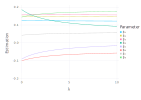

In [10]:
plot(df, x=:λ, y=:Estimation, color=:Parameter, Geom.line)

### (d) Estimez λ en minisant l'erreur de prédiction sur l'échantillon de validation

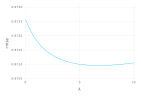

In [11]:

df = DataFrame(λ = Float64[], rmse = Float64[])

transdata = StatsBase.transform(dt, Matrix{Float64}(valid))

X_valid = transdata[:,1:8]
y_valid = transdata[:,9]

for λ in 0:.01:10

    β̂ = (X'X + λ*I)\X'y
    
    ŷ = X_valid*β̂
    
    rmse = StatsBase.rmsd(ŷ, y_valid)
    
    push!(df, [λ, rmse])
    
end

plot(df, x=:λ, y=:rmse, Geom.line)


In [12]:
λ̂ = df.λ[argmin(df.rmse)]

6.73

### (e) Tracez la loi *a posteriori* marginale du coefficient de régression correspond à la variable *age*.

Est-ce que cette variable possède un pouvoir prédictif significatif ? 

Utiliser la commande `LocationScale(μ, sqrt(Σ), TDist(ν))` pour créer un objet de type *loi de Student multidimensionnelle à ν degrés de liberté, de paramètre de localisation μ et de paramètre d'échelle Σ*.

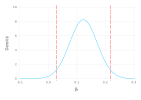

In [13]:
β̂ = (X'X + λ̂*I)\X'y

s² = (y'y - β̂'*(X'X + λ̂*I)*β̂)/n

Σ = s²*inv(X'X + λ̂*I)

pd = LocationScale(β̂[1],sqrt(Σ[1,1]),TDist(n-m))

plot(x->pdf(pd,x), -.1, .3,
    xintercept = quantile.(pd, [.025, .975]), Geom.vline(style=:dash, color="red"),
    Guide.xlabel("β₁"), Guide.ylabel("Densité"))


### (f) Implémentez l'échantillonnage de Gibbs pour générer un échantillon de la loi *a posteriori* de la régression ridge.

Utilisez votre estimation λ̂.

## Exercice 2 : Exploration stochastique de l'espace des modèles [OPTIONEL]

Dans cet exercice, on reprend le jeux de données *bodyfat.csv* comportant le pourcentage de gras de 20 patientes en fonction des variables explicatives suivantes :

$x_1$ : l'épaisseur des plis de la peau des triceps (en mm) ;<br/>
$x_2$ : le tour de cuisse (en mm) ;<br/>
$x_3$ : la circonférence du bras en (mm).<br/>

Nous allons implémenter l'échantillonnage de Gibbs pour explorer de façon stochastique l'espace des modèele. Puisqu'il n'y a que 3 variables explicatives dans ce cas-ci, il est possible de déterminer quel est le *vrai* meilleur modèle par énumération complète de tous les modèles.


In [14]:
# Chargement des données

data = CSV.read("bodyfat.csv", DataFrame)
first(data, 5)

,Triceps,Thigh,Midarm,Bodyfat
,Float64,Float64,Float64,Float64
1,19.5,43.1,29.1,11.9
2,24.7,49.8,28.2,22.8
3,30.7,51.9,37.0,18.7
4,29.8,54.3,31.1,20.1
5,19.1,42.2,30.9,12.9


In [15]:
# Standardisation des variables
dt = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(data), dims=1)
transdata = StatsBase.transform(dt, Matrix{Float64}(data))

X = transdata[:,1:3]
y = transdata[:,4]

n = length(y)
m = size(X,2)

3

In [16]:
# Énumration de tous les modèles possibles

itr = reverse.(Iterators.product(fill(0:1,m)...))[:]

M = BitArray[]
for i in eachindex(itr)
   push!(M, [itr[i]...] .== 1)
end
M

8-element Vector{BitArray}:
 [0, 0, 0]
 [0, 0, 1]
 [0, 1, 0]
 [0, 1, 1]
 [1, 0, 0]
 [1, 0, 1]
 [1, 1, 0]
 [1, 1, 1]

### (a) Écrivez une fonction permettant de calculer le BIC d'un modèle.

La fonction devrait prendre comme argument un vecteur de booléens indicant quelles variables sont incluses dans le modèle. La fonction devrait prendre en argument par exemple le vecteur [true true true].

In [17]:
function getbic(γ::BitArray)
    
    if any(γ)
    
        Xᵧ = X[:,γ]

        β̂ = (Xᵧ'Xᵧ)\Xᵧ'y

        μ̂ = Xᵧ*β̂

        e = y-μ̂

        σ̂² = dot(e,e)/(n-m) 

        BIC = sum(logpdf.(Normal.(μ̂,sqrt(σ̂²)),y)) - (count(γ)+1)/2*log(n)
        
    else
        
        σ̂² = dot(y,y)/(n-m)
        
        BIC = sum(logpdf.(Normal.(0,sqrt(σ̂²)),y)) - (count(γ)+1)/2*log(n)
        
    end
    
    return BIC
    
end

getbic (generic function with 1 method)

### (b) Calculer le BIC pour chacun des modèles possibles

Quel est le meilleur modèle ?

In [18]:
BIC = getbic.(M)

8-element Vector{Float64}:
 -29.488893151972693
 -30.78176951264226
 -16.244618147055984
 -17.536369508313584
 -18.570129722290112
 -17.05936046854954
 -17.43151125814423
 -17.819953137176938

In [19]:
ind = argmax(BIC)
M[ind]

3-element BitVector:
 0
 1
 0

### (c) Exécuter la cellule suivante pour parcourir l'espace des modèles avec l'échantillonnage de Gibbs

In [20]:
function softmax(x::AbstractVector{<:Real})
    
    z = x .- maximum(x)
    
    e = exp.(z)
    
    s = e ./ sum(e)
    
end

softmax (generic function with 1 method)

In [21]:
niter = 10000

γ = trues(3,niter)

for i=2:niter
   γ[:,i] = γ[:,i-1]
    for j=1:m
        
        η₀ = γ[:,i]
        η₁ = γ[:,i]
        η₀[j] = false
        η₁[j] = true
        
#         θ = exp(getbic(η₁)) / ( exp(getbic(η₀)) + exp(getbic(η₁)))
        s = softmax(getbic.([η₀, η₁])) # évite l'instabilité numérique
        θ = s[2]
        
        γ[j,i] = rand(Bernoulli(θ))
        
    end
end

### (d) Exécuter les cellules suivantes pour déterminer le modèle choisi pour chacune des itérations

In [22]:
function modelid(M::Vector{BitArray},γ::BitArray)
    
    @assert length(γ)==length(M[1])
    
    ind = 1
    
    while M[ind] != γ
        ind +=1
    end
    
    return ind
        
end

modelid (generic function with 1 method)

In [23]:
id = [modelid(M,γ[:,i]) for i=1:size(γ,2)]

df = DataFrame(Itération = 1:niter, Modèle = id)

groupby(df, :Modèle)

nb = combine(groupby(df, :Modèle), :Itération=> length => :Itérations)

sort!(nb, :Itérations, rev=true)

,Modèle,Itérations
,Int64,Int64
1,3,4361
2,6,1886
3,7,1242
4,4,1207
5,8,878
6,5,426


### (e) Selon les résultats en (d), quel est le meilleur modèle ? Est-ce cohérent avec le BIC calculé en (a) ?